# Cholesterol and Blood Pressure Metrics: A Predictive Model for Heart Disease
#### Benjamin Lee, 79964508

## Introduction
### I. Background

The human body's vital organs depend on an adequate supply of oxygen, which is distributed through blood circulation. Conditions which impede proper blood supply from the heart are medically defined as heart disease. 

According to an article from the Government of Canada's Public Health Agency, factors such as high cholesterol levels and high blood pressure are major contributors to heart disease, so the objective of this study is to determine whether blood pressure and cholesterol levels can help predict whether a patient has heart disease. 

### II. Research Question

In this study, I investigate the following inquiry: How accurate can we predict whether an individual has a heart disease based on cholesterol and blood pressure (and thus, are these predictors sufficient for clinical use)?

### III. Dataset

To pursue this inquiry, I used data for heart disease diagnoses from the UC Irvine (UCI) Machine Learning Repository. It includes databases from four regions: Cleveland, Hungary, Switzerland, and VA Long Beach.

## Preliminary Exploratory Data Analysis

In [2]:
# Loading relevant packages from library
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### I. Reading Data into Jupyter Notebook 

In [3]:
# Obtained the heart disease datasets from UCI's heart disease data archives
raw_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)
head(raw_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### II. Tidying Raw Data

#### Key:

trestbps - Resting Blood Pressure (mm Hg)

chol - Serum Cholesterol (mg/dL)

num - Presence of heart disease

In [4]:
# Wrangled and tidied the data
heart_data <- raw_data |>
mutate(trestbps = X4, chol = X5, num = X14) |> # Defining the variables of interest (based on the key provided by UCI)
select(trestbps, chol, num) |>
# ?case_when
mutate(num = case_when(num > 0 ~ "Yes", num == "0" ~ "No")) |> # Changing num to binary: heart disease or no heart disease
mutate(num = as.factor(num), chol = as.numeric(chol), trestbps = as.numeric(trestbps)) |>
filter(trestbps != "?", chol != "?") # Omitting observations which had missing values
head(heart_data)

trestbps,chol,num
<dbl>,<dbl>,<fct>
145,233,No
160,286,Yes
120,229,Yes
130,250,No
130,204,No
120,236,No


### III. Standardization of Variables, Data Visualization

In [5]:
# standardized the predictors (resting blood pressure and serum cholesterol levels)
data_recipe <- recipe(num ~ trestbps + chol, data = heart_data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

data_scaled <- data_recipe |>
            prep() |> 
            bake(heart_data)

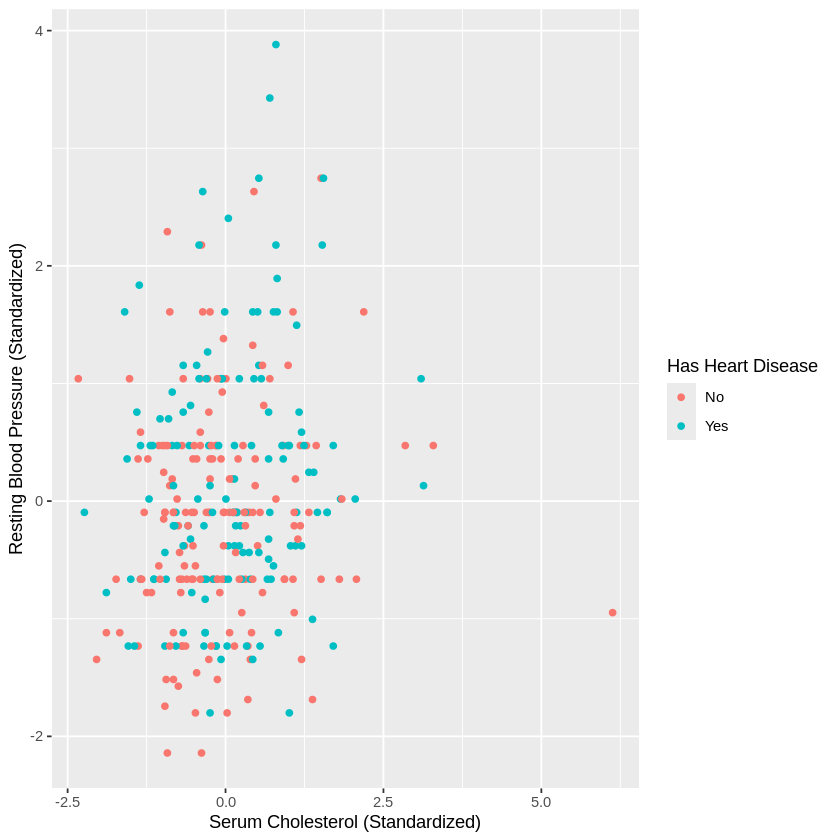

In [6]:
# Prepared a scatterplot for preliminary analysis
data_plot <- data_scaled |>
    ggplot(aes(x = chol, y = trestbps)) +
    geom_point(aes(colour = num)) +
    labs(x = "Serum Cholesterol (Standardized)", y = "Resting Blood Pressure (Standardized)", colour = "Has Heart Disease")
data_plot

## Methods

#### I. Data Analysis
To build the classifier, I will use the k-nearest neighbours algorithm. Then, I will tune the classifier and use five-fold cross-validation to determine whether this classification model is suitable for predicting heart disease.

#### II. Variables
In this study, I will use serum cholesterol levels and resting blood pressure levels as predictors for the presence of heart disease.

#### III. Visualization Method
The primary method for visualizing the data will be through scatterplots. However, I may occasionally use a table to depict the steps that I am taking when building the classifier for this dataset.

## Expected Outcomes and Signifiance

#### I. Hypothesis
I expect to find cholesterol and blood pressure levels to be fairly strong predictors for heart disease - that an individual with a high blood pressure and serum cholesterol level is predicted to have heart disease, through the k-nearest neighbours model.

#### II. Impact

Healthcare professionals may be able to verify if their patients have heart disease using this simple model.

#### III. Implications and Further Research

While this model is beneficial, it is important to consider that heart disease is much more complex than high cholesterol and blood pressure levels. 

Thus, I propose that other variables must be analyzed in order to make such a diagnosis (i.e. Could obesity also be a predictor for heart disease? How might adding this variable change the accuracy of the classification model?). 

However, this requires a more complete dataset, since the dataset provided by UCI only had these two predictors which were relevant to heart disease diagnosis - as per the Canadian Public Health Agency.

## Bibliography

#### Dataset
- Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X
#### Heart Disease Information
-  Public Health Agency of Canada (2017). Heart diseases and conditions [Education and awareness]. https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions.html
